In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.optimize import curve_fit
plt.style.use('default')
from scipy.special import hyp2f1
import re
from tabulate import tabulate
import seaborn as sns

#### Functions

In [2]:
# functions needed to load and plot the data
pattern = re.compile(r'\d+')

#This function is modified to return Xarray instead of Dictionary. 
def read_cbd(file_path):
    '''
    read_cbd: reads the cbd file data
    Arguments:
    file_path-- path where the file is located
    Return--
    xr_data-- data_matrix: 3-D matrix of size (N_x, N_y, N_z)
          x-coord: 1-D array of  x-coordinates size (N_x,1)
          y-coord: 1-D array of  y-coordinates size (N_y,1)
          z-coord: 1-D array of  z-coordinates size (N_z,1)
    '''
    f = open(file_path, "rb")
    id = np.fromfile(f, dtype=np.int64, count=1)[0]
    if id == 288230376151834571:
        T = np.float32
    elif id == 576460752303546315:
        T = np.float64
    else:
        raise ValueError("Invalid ID")
    N = tuple(np.fromfile(f, dtype=np.int64, count=3))
    xmin = tuple(np.fromfile(f, dtype=np.float64, count=3))
    xmax = tuple(np.fromfile(f, dtype=np.float64, count=3))
    x1, x2, x3 = (np.fromfile(f, dtype=np.float64, count=n) for n in N)
    data1 = np.fromfile(f, dtype=T, count=np.prod(N)).reshape(N, order="F")
    #dic = {"data":data1, "x-coord":x1, "y-coord":x2, "z-coord":x3, "diagonal_points":[xmin,xmax]}
    xr_data = xr.DataArray(
        data1,
        dims = ("x", "y", "z"),
        coords = { "x" : x1,
                  "y" : x2,
                  "z" : x3
        }   
    )
    f.close()
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array
    
def h5_in_xarray(field):
    #hf = h5py.File(filepath, 'r')
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def output_keylist(f, con1, con2, domh=None, aspect=None):
    '''
    Arguments--
    f - the dictionary containing all the data
    con1 - what contains in the list (often the packing density)
    con2 - a "startswith condition"
    domh - if you want a particular domain height (string)
    aspect - if you want a particular aspect ratio
    '''
    key_list = list(f.keys())
    key_list.sort()
    key_list = [match for match in key_list if con1 in match and match.startswith(con2)]
    if domh == None:
        pass
    else:
        key_list = [match for match in key_list if "_"+domh+"x" in match]
        
    if aspect == None:
        pass
    else:
        if aspect == 1.5:
            match_list = ["_4x6", "_8x12", "_16x24"]
        elif aspect == 3:
            match_list = ["_4x12", "_8x24", "_16x48"]
        else:
            match_list = ["_4x18", "_8x36", "_16x72"]
        
        for key in key_list:
            count = 0
            for match in match_list:
                if match not in key:
                    count += 1
            if count == 3:
                # print(key)
                key_list.remove(key)

    return key_list

### Loading averaged fields

In [3]:
# Let's load the entire data
field_list = ['u', 'v', 'w', 'uu', 'uv', 'uw', 'vv', 'vw', 'ww']
f = {} # Loads all the variables
#h5_files = ['chan_l4_8x24x48.h5']
h5_files = os.listdir('/home/as2204/TACC_postprocess/pressure_corrected_domain_averages')
h5_files = [match for match in h5_files if "chan" in match and "_16x" not in match and "_12x" not in match and "ruu" not in match and "rvv" not in match]
filepath = '/home/as2204/TACC_postprocess/pressure_corrected_domain_averages'

for sim in h5_files:
    # print(sim)
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

h5_files = os.listdir('/home/as2204/TACC_postprocess/pressure_corrected_domain_averages')
h5_files = [match for match in h5_files if "restart0" in match and "_12x" not in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    # sim = sim[4:-12]
    sim = re.search('chan(_l\d+_\d+x\d+x\d+).*', sim).group(1)
    # print("%s" % sim)
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    if "l4_16x48" in sim or "l4_16x72" in sim or "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "chan%s_restart%d_run2.h5" % (sim, i)
            # print(sim_name)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            for field in field_list:
                f['%s%s' % (field, sim)] += h5_in_xarray(field)
        
        for field in field_list:
            f['%s%s' % (field, sim)] /= 8
    else:
        for field in field_list:
            f['%s%s' % (field, sim)] /= 4

h5_files = os.listdir('/home/as2204/TACC_postprocess/pressure_corrected_domain_averages')
h5_files = [match for match in h5_files if "restart0" in match and "_12x" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    # sim = sim[4:-12]
    sim = re.search('chan(_l\d+_\d+x\d+x\d+).*', sim).group(1)
    # print("%s" % sim)
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 2):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    for field in field_list:
        f['%s%s' % (field, sim)] /= 2

### Figure 2

Text(0.06, 0.5, '$x_3/L_3$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


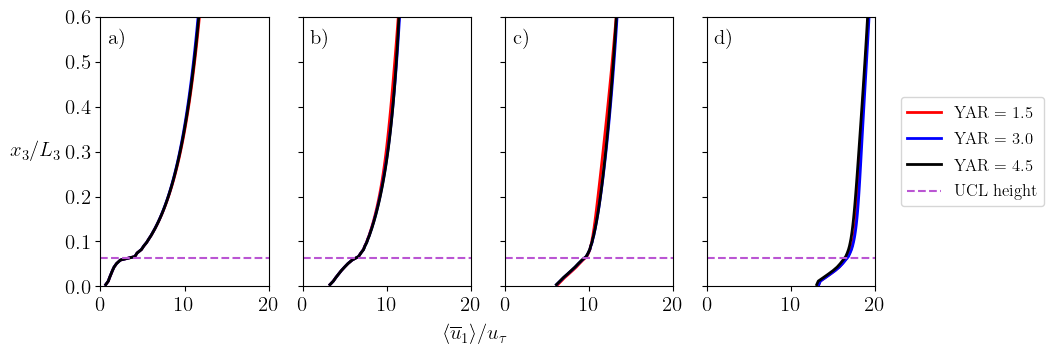

In [4]:
from matplotlib import rc
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    key_list = output_keylist(f, pack_den, "u_", domh="16")
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        if index == 3:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:80], f["%s" % key]['z'][:80] / delta, clist[index1], linewidth=2, label='YAR = %.1f' % float(ly/delta))
        else:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:80], f["%s" % key]['z'][:80] / delta, clist[index1], linewidth=2)
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 0.6)
    axs[index].set_xlim(0, 20)
    axs[index].plot(np.linspace(0, 20, 20), np.ones(20) * 1/delta, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.5, -0.025, r'$\langle\overline{u}_1\rangle/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$x_3/L_3$', ha='center', va='center', rotation='horizontal', fontsize=15)
# plt.tight_layout()
# fig1.savefig('eps_figs/vel_Yaspectimpact_limupdated.pdf', format='pdf', bbox_inches="tight")

### Figure 3

In [5]:
h5_files_list = os.listdir('/home/as2204/TACC_postprocess/pressure_corrected_domain_averages')
h5_files = [match[4:-3] for match in h5_files_list if "_16x" not in match and "_12x" not in match and "chan" in match and "ruu" not in match and "rvv" not in match]
h5_files_16 = [match[4:-12] for match in h5_files_list if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
h5_files += h5_files_16
#print(len(h5_files))

# computing variances
# rs["uw%d" % (j)] = f["uw%d" % (j)].mean(dim = ['x', 'y']) - (f["u%d" % (j)] * f["w%d" % (j)]).mean(dim = ['x', 'y'])
var_list = ['uu', 'uv', 'uw', 'vv', 'vw', 'ww']
temp = {}

for sim in h5_files:
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

# Let's add a dispersive flux component to this variance
# dc["uw%d" % (j)] = (f["u%d" % (j)]*f["w%d" % (j)]).mean(dim = ['x', 'y']) - f["u%d" % (j)].mean(dim = ['x', 'y']) * f["w%d" % (j)].mean(dim = ['x', 'y'])
disp = {}

for sim in h5_files:
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])


# calculating total stress
stress = {}

for sim in h5_files:
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]

Text(0.06, 0.5, '$x_3/L_3$')

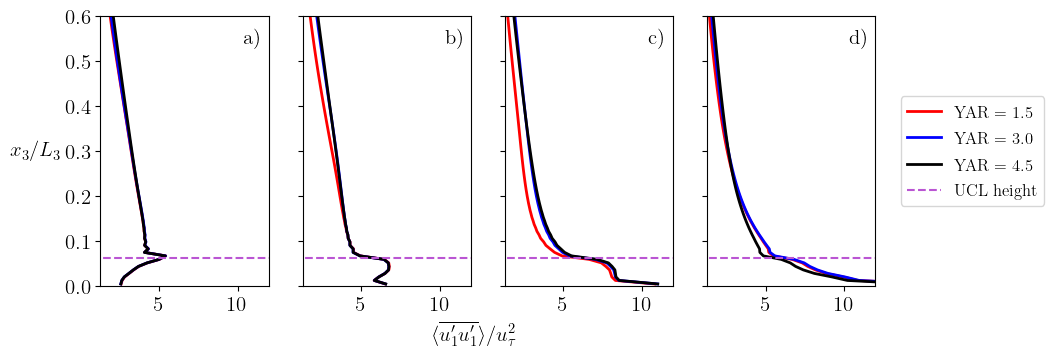

In [6]:
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    key_list = output_keylist(f, pack_den, "uu_", domh="16")
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        if index == 3:
            axs[index].plot(stress["%s" % key][:80], stress["%s" % key]['z'][:80] / delta, clist[index1], linewidth=2, label='YAR = %.1f' % float(ly/delta))
        else:
            axs[index].plot(stress["%s" % key][:80], stress["%s" % key]['z'][:80] / delta, clist[index1], linewidth=2)

    plt.text(0.9, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 0.6)
    axs[index].set_xlim(1.25, 12)
    axs[index].plot(np.linspace(0, 20, 20), np.ones(20) * 1/delta, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.5, -0.025, r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u_{\tau}^2$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$x_3/L_3$', ha='center', va='center', rotation='horizontal', fontsize=15)
# plt.tight_layout()
# fig1.savefig('eps_figs/var_Yaspectimpact_limupdated.pdf', format='pdf', bbox_inches="tight")

### Figure 9

In [7]:
def create_xarray_2d(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("y", "z"),
        coords = {"y" : u['y'],
                "z" : u['z']
        }
    )

    return new_array

def z_derivative_2d(f):
    dz = f['z'][1].values - f['z'][0].values 
    dfdz = np.zeros(f.shape)
    dfdz[:, 0] = (f[:, 1].values - f[:, 0].values) / dz
    dfdz[:, -1] = (f[:, -1].values - f[:, -2].values) / dz
    dfdz[:, 1:-1] = (f[:, 2:].values - f[:, :-2].values) / (2 * dz)

    dfdz_xarray = create_xarray_2d(f)
    dfdz_xarray.values = dfdz
    return dfdz_xarray


def y_derivative_fft(f, Ly):
    # f should be streamwise averaged 2d field
    ny, nz = f.shape
    k = 2 *np.pi *np.fft.fftfreq(ny) / Ly
    dfdy = np.empty((f.shape))

    for i in range(nz):
        f_hat = np.fft.fft(f[:,i])
        dfdy_hat = 1j * k * f_hat
        dfdy[:, i] = np.fft.ifft(dfdy_hat) * ny

    dfdy_xarray = create_xarray_2d(f)
    dfdy_xarray.values = dfdy
    return dfdy_xarray

def compute_streamwise_vorticity(f, key):
    # f should be the entire dictionary
    # key should be like _l2_4x.. without the variable
    vort = np.empty(f["w%s" % key].shape)
    pattern = re.compile(r'\d+') 
    lengths = pattern.findall(key)
    z_der = z_derivative_2d(f["v%s" % key].mean(dim=['x']))
    y_der = y_derivative_fft(f["w%s" % key].mean(dim=['x']), int(lengths[2]))
    vort = y_der - z_der
    zero_cube_loc = find_cuboids_yz(4, 8, int(lengths[2]), int(lengths[1]), int(lengths[0]) - 1)
    vort.values = vort.values * zero_cube_loc
    return vort, zero_cube_loc

def find_cuboids_yz(xyreso, zreso, ly, lz, gap):
    ny = ly*xyreso
    nz = lz*zreso
    yz_array = np.ones((ny, nz))
    y_init = int(gap * xyreso / 2)
    yz_array[y_init:y_init+xyreso+1, :zreso] = 0
    while y_init < (ny - (gap + 1) * xyreso):
        y_init += (gap + 1) * xyreso
        yz_array[y_init:y_init+xyreso+1, :zreso] = 0
    return yz_array

# pseudo-spectral derivative from Weiyi
def derivative_fft_y(q,L_y):
    """
    Function to take the spatial derivative on the second(spanwise) direction via fft

    Parameters
    ----------
    q: array
        Quantity to be taken the derivative of
    L_y: float
        Domain size on the spanwise direction

    Return
    ------
    dqdx: array
        Derivative of q 
    """
    nx = np.size(q[:,0,0])
    ny = np.size(q[0,:,0])
    nz = np.size(q[0,0,:])
    norm=1.0/nx/ny
    ky = np.empty([nx,ny])
    ky[:,:] = 0.0
    for i in range(1,ny//2):
        ky[:,i]=i
        ky[:,ny-i]=-i
    ky = 2.0*np.pi*ky/L_y
    dqdy = 0.0*q
    eye = complex(0.0,1.0) 

    for jk in range(nz):
        q_hat=np.fft.fft2(q[:,:,jk]*norm)
        dqdy_hat = eye*ky*q_hat
        dqdy[:,:,jk] = np.fft.ifft2(dqdy_hat)*nx*ny
    dqdy = np.real(dqdy)
    return dqdy


# Let's also try to make a dark line around cubes
def find_cuboid_midpoint(xyreso, ly, gap):
    locs = []
    ny = ly*xyreso
    y_init = int(gap * xyreso / 2)
    locs.append(y_init + xyreso/2)
    while y_init < (ny - (gap + 1) * xyreso):
        y_init += (gap + 1) * xyreso
        locs.append(y_init + xyreso/2)
    return locs

def plot_cubes(key, ax):
    pattern = re.compile(r'\d+') 
    lengths = pattern.findall(key)
    locs = find_cuboid_midpoint(4, int(lengths[2]), int(lengths[0]) - 1)
    # dx = 1/4
    x = np.array([-2, -1, 0, 1, 2])
    for i in range(len(locs)):
        x_new = locs[i] + x
        x_new[0] += -0.5
        x_new[-1] += 0.5
        ax.plot(x_new/4, np.ones(5), 'k', alpha=0.75)
        ax.plot(x_new[0]/4 * np.ones(9), np.arange(9)/8, 'k', alpha=0.75)
        ax.plot(x_new[-1]/4 * np.ones(9), np.arange(9)/8, 'k', alpha=0.75)

In [8]:
def find_cuboid_midpoint2(ly, lz, gap_for_16):
    locs = []
    ny = 288
    yreso = ny / ly
    yreso_per_cube = 4
    comprs_fac = lz / 16
    gap = gap_for_16 * comprs_fac
    y_init = round(gap * yreso / 2)
    locs.append(y_init +yreso_per_cube/2)
    while y_init < (ny - (gap + comprs_fac) * yreso):
        y_init += round((gap + comprs_fac) * yreso)
        locs.append(y_init + yreso_per_cube/2)
    return locs

def plot_cubes2(key, gap_for_16, ax):
    pattern = re.compile(r'\d+') 
    lengths = pattern.findall(key)
    locs = find_cuboid_midpoint2(int(lengths[3]), int(lengths[2]), gap_for_16)
    comprs_fac = int(lengths[2]) / 16
    x = np.array([-2, -1, 0, 1, 2])
    for i in range(len(locs)):
        x_new = locs[i] + x
        x_new[0] += -0.5 * comprs_fac
        x_new[-1] += 0.5 * comprs_fac
        ax.plot(x_new/4 * comprs_fac, np.ones(5), 'k', alpha=0.75)
        ax.plot(x_new[0]/4 * comprs_fac * np.ones(9), np.arange(9)/8, 'k', alpha=0.75)
        ax.plot(x_new[-1]/4 * comprs_fac * np.ones(9), np.arange(9)/8, 'k', alpha=0.75)


def compute_streamwise_vorticity2(f, key):
    # f should be the entire dictionary
    # key should be like _l2_4x.. without the variable
    vort = np.empty(f["w%s" % key].shape)
    pattern = re.compile(r'\d+') 
    lengths = pattern.findall(key)
    z_der = z_derivative_2d(f["v%s" % key].mean(dim=['x']))
    y_der = y_derivative_fft(f["w%s" % key].mean(dim=['x']), int(lengths[2]))
    vort = y_der - z_der
    sy_for_16 = round(1000 / int(lengths[0]))
    # sy_for_16 = sy * 16 / int(lengths[2])
    gap_for_16 = sy_for_16 - 1
    zero_cube_loc = find_cuboids_yz2(8, int(lengths[3]), int(lengths[2]), gap_for_16)
    vort.values = vort.values * zero_cube_loc
    return vort, zero_cube_loc, gap_for_16

def find_cuboids_yz2(zreso, ly, lz, gap_for_16):
    ny = 288    # for the heighest aspect ratio
    yreso = round(ny/ly)
    yreso_per_cube = 4
    nz = lz*zreso
    comprs_fac = lz / 16
    gap = gap_for_16 * comprs_fac
    yz_array = np.ones((ny, nz))
    y_init = round(gap * yreso / 2)
    yz_array[y_init:y_init+yreso_per_cube+1, :zreso] = 0
    while y_init < (ny - (gap + comprs_fac) * yreso):
        y_init += round((gap + comprs_fac) * yreso)
        yz_array[y_init:y_init+yreso_per_cube+1, :zreso] = 0
    return yz_array

In [9]:
key0 = "_l12_16x72x96" 
key1 = "_l12_8x36x48"    
key2 = "_hxsx83e-3_8x36x48"
field_list = ['u', 'v', 'w']
# f = {}
filepath = '/home/as2204/TACC_postprocess/pi_based_averages'
h5_file = "chan%s.h5" % key2
hf = h5py.File('%s/%s' % (filepath, h5_file), 'r')
for field in field_list:
    f['%s%s' % (field, h5_file[4:-3])] = h5_in_xarray(field)

/home/as2204/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/as2204/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/as2204/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.53, 1.05, '(c)')

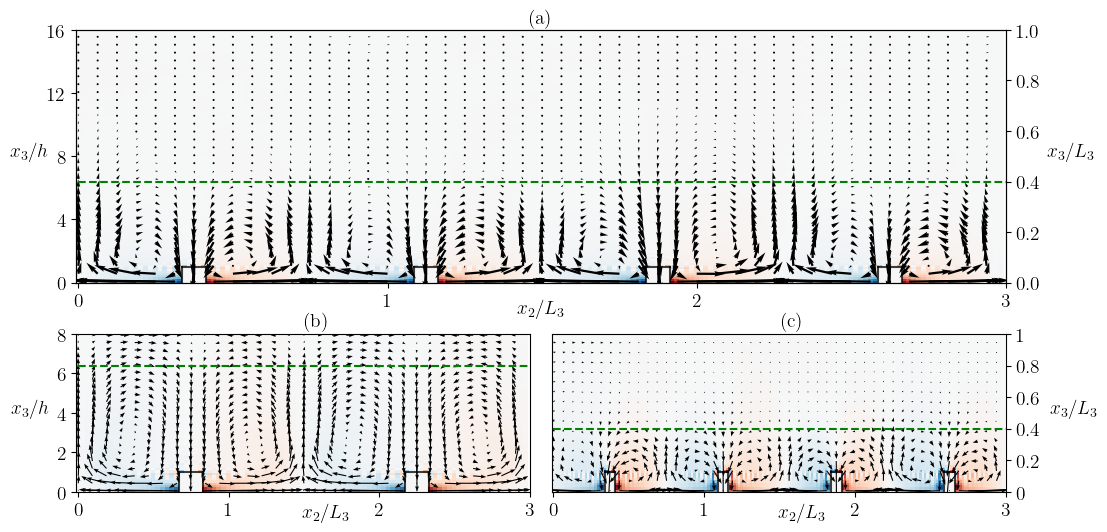

In [10]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=14,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.05, height_ratios=[2, 1.25])
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

#########################################################################################################
vort, cube_loc = compute_streamwise_vorticity(f, key0)
vort[:int(4*3*16), :].transpose().plot.pcolormesh(ax=ax0, cmap='RdBu_r', add_colorbar=False)
Y, Z = np.meshgrid(f["u%s" % key0]['y'][:int(4*3*16)],  f["u%s" % key0]['z'])
l = 4
lz = 4
ax0.quiver(Y[::l, ::lz], Z[::l, ::lz], (f["v%s" % key0].mean(dim=['x']) * cube_loc)[:int(4*3*16):l, ::lz].transpose(), (f["w%s" % key0].mean(dim=['x']) * cube_loc)[:int(4*3*16):l, ::lz].transpose(), scale=30, headwidth=2.5)
plot_cubes(key0, ax0)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.plot(np.linspace(0, 48, 100), 6.4 * np.ones(100), 'g--')

# ax = plt.gca()    # Get current axis
ax02 = ax0.twinx()  # make twin axis based on x

plt.text(1.07, 0.5, r'$x_3/L_3$', horizontalalignment='center', transform=ax0.transAxes,fontsize=14)
plt.text(-0.05, 0.5, r'$x_3/h$', horizontalalignment='center', transform=ax0.transAxes,fontsize=14)
plt.text(0.5, -0.12, r'$x_2/L_3$', horizontalalignment='center', transform=ax0.transAxes,fontsize=14)

ax0.set_yticks([0, 4, 8, 12, 16])
ax0.set_xticks([0, 16, 32, 48])
ax0.set_xticklabels([0, 1, 2, 3])
#########################################################################################################

vort, cube_loc = compute_streamwise_vorticity(f, key1)
vort[:int(4*3*8), :].transpose().plot.pcolormesh(ax=ax1, cmap='RdBu_r', add_colorbar=False)
#f["v%s" % key].mean(dim=['x']).transpose().plot.pcolormesh(cmap='coolwarm', vmin=-5, vmax=5)
Y, Z = np.meshgrid(f["u%s" % key1]['y'][:int(4*3*8)],  f["u%s" % key1]['z'])
l = 3
ax1.quiver(Y[::l, ::l], Z[::l, ::l], (f["v%s" % key1].mean(dim=['x']) * cube_loc)[:int(4*3*8):l, ::l].transpose(), (f["w%s" % key1].mean(dim=['x']) * cube_loc)[:int(4*3*8):l, ::l].transpose(), scale=30, headwidth=3.5)
plot_cubes(key1, ax1)
ax1.plot(np.linspace(0, 48, 100), 6.4 * np.ones(100), 'g--')
# plt.title("Streamwise vorticity - config %s" % key[1:])
plt.text(-0.1, 0.5, r'$x_3/h$', horizontalalignment='center', transform=ax1.transAxes,fontsize=14)
ax1.set_ylabel('')
plt.text(0.55, -0.16, r'$x_2/L_3$', horizontalalignment='center', transform=ax1.transAxes,fontsize=14)
ax1.set_xlabel('')
ax1.set_xticks([0, 8, 16, 24])
ax1.set_xticklabels([0, 1, 2, 3])
########################################################################################################

nums = pattern.findall(key2)
pack_den = nums[0]
vort, cube_loc, gap_for_16 = compute_streamwise_vorticity2(f, key2)
vort[:int(4*3*16), :].transpose().plot.pcolormesh(ax=ax2, cmap='RdBu_r', add_colorbar=False)
# Y, Z = np.meshgrid(vort['y'], vort['z'])
# vort_np = vort.values.transpose()
# plt.pcolormesh(Y, Z, vort_np)
#f["v%s" % key].mean(dim=['x']).transpose().plot.pcolormesh(cmap='coolwarm', vmin=-5, vmax=5)
Y, Z = np.meshgrid(f["u%s" % key2]['y'][:int(4*3*16)],  f["u%s" % key2]['z'])
l = 4
ax2.quiver(Y[::l, ::l], Z[::l, ::l], (f["v%s" % key2].mean(dim=['x']) * cube_loc)[:int(4*3*16):l, ::l].transpose(), (f["w%s" % key2].mean(dim=['x']) * cube_loc)[:int(4*3*16):l, ::l].transpose(), scale=19, headwidth=3.5)
plot_cubes2(key2, gap_for_16, ax2)
# plt.title(r'$s_y/\delta = %.2f$, Domain height = %d' % (float(1000/int(pack_den)/16), int(nums[2])))
plt.text(1.15, 0.5, r'$x_3/L_3$', horizontalalignment='center', transform=ax2.transAxes,fontsize=14)
plt.text(0.55, -0.16, r'$x_2/L_3$', horizontalalignment='center', transform=ax2.transAxes,fontsize=14)
ax2.set_xlabel('')
ax2.plot(np.linspace(0, 48, 100), 3.2 * np.ones(100), 'g--')
ax2.set_yticks([0, 1.6, 3.2, 4.8, 6.4, 8])
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_xticks([0, 8, 16, 24])
ax2.set_xticklabels( [0, 1, 2, 3])
ax2.yaxis.tick_right()
ax2.set_ylabel('')
##########################################################################################################
plt.text(0.5, 1.025, r'(a)', horizontalalignment='center', transform=ax0.transAxes,fontsize=14, weight='bold')
plt.text(0.53, 1.05, r'(b)', horizontalalignment='center', transform=ax1.transAxes,fontsize=14, weight='bold')
plt.text(0.53, 1.05, r'(c)', horizontalalignment='center', transform=ax2.transAxes,fontsize=14, weight='bold')
# fig.savefig('eps_figs/vorticity_updated.pdf', format='pdf', bbox_inches="tight")